In [514]:
import numpy as np
import os
import numpy as np
import uncertainties as u
from uncertainties import ufloat
from uncertainties.umath import sqrt
from uncertainties.umath import __all__
from uncertainties.umath import *
ulog = u.wrap(np.log)
upower = u.wrap(np.power)
umultiply = u.wrap(np.multiply)
udivide = u.wrap(np.divide)
import uncertainties.unumpy as unp
import scipy.constants
import os
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pandas # pip install Jinja2
import pint # pip install pint OR conda install pint
units = pint.UnitRegistry()
units.default_format = '~'
units.setup_matplotlib(True)
import warnings
warnings.simplefilter("ignore")

cm = 1/2.54

def extr_values(np_arr):
    return unp.nominal_values(np_arr)

def extr_sig(np_arr):
    return unp.std_devs(np_arr)

def strip_units(np_arr):
    return np.array([(a.to_base_units().magnitude if type(a)!=float and hasattr(a, 'magnitude') else a) for a in np_arr])

In [515]:
# Range stuff
def Range(A,B,C,E):
  return A*E*(1-B/(1+C*E))

def RangeOfEnergy_rho_times_x(energy):
    a=1.479*0.001
    B=0.9852
    C=3.73
    A=1/a
    return Range(A,B,C, energy)
    
def Range_SamplePlot():
    import numpy as np
    energie = np.linspace(0.001,3,100)
    import matplotlib.pyplot as plt
    plt.loglog(RangeOfEnergy_rho_times_x(energie),energie)
    plt.grid(True, which="both", ls="-")
    plt.ylabel("Electron Energy (MeV)")
    plt.xlabel("Range in Al (mg*cm^(-2))")
    plt.show()
#Range_SamplePlot()

In [516]:
# Find x value for a given y

def interp_x_from_y(input, x, y):
    return x[y.searchsorted(input, 'left')]

# Helper lists outside of function so that we only compute it once
xxxxxx_Energies = np.linspace(0.0001, 5, 100000)
xxxxxx_RhoX = RangeOfEnergy_rho_times_x(xxxxxx_Energies)

# input: rho*x (uncertainty value)
# output: E(px)
def Approx_E_of_px(rho_x, sig_rho_x, customrange=False, E_range_min=1e+0, E_range_max=1e+0, nologlog=False):
    lower_rho_x = rho_x - sig_rho_x
    upper_rho_x = rho_x + sig_rho_x

    energies = xxxxxx_Energies if not customrange else np.linspace(E_range_min, E_range_max, 100000)
    RhoX = xxxxxx_RhoX if not customrange else RangeOfEnergy_rho_times_x(energies)

    energy = interp_x_from_y(rho_x, energies, RhoX)
    energy_lower = interp_x_from_y(lower_rho_x, energies, RhoX)
    energy_upper = interp_x_from_y(upper_rho_x, energies, RhoX)
    if not nologlog:
        plt.loglog(RhoX,energies)
    else:
        plt.plot(RhoX, energies)
    plt.hlines(energy, np.min(RhoX), np.max(RhoX), colors='red')
    plt.vlines(rho_x, np.min(energies), np.max(energies))
    plt.grid(True, which="both", ls="-")
    plt.ylabel("Electron Energy (MeV)")
    plt.xlabel(r'$\rho x$ $(\mathrm{mg~cm^{-2}})$')
    plt.show()

    return energy, energy_upper - energy_lower

rho*x =  [0.0+/-0.1345 0.06725+/-0.13450005808548932 0.1345+/-0.13450023234180675 0.20174999999999998+/-0.1345005227685008 0.269+/-0.1345009293648189 0.33625+/-0.13450145212970752 0.40349999999999997+/-0.13450209106181213 0.47074999999999995+/-0.13450284615947725 0.538+/-0.1345037174207464 0.60525+/-0.13450470484336227 0.6725+/-0.13450580842476656 0.73975+/-0.13450702816210014 0.8069999999999999+/-0.1345083640522031 0.87425+/-0.1345098160916147 0.9414999999999999+/-0.13451138427657341 1.00875+/-0.13451306860301715 1.076+/-0.13451486906658314] g / cm ** 2


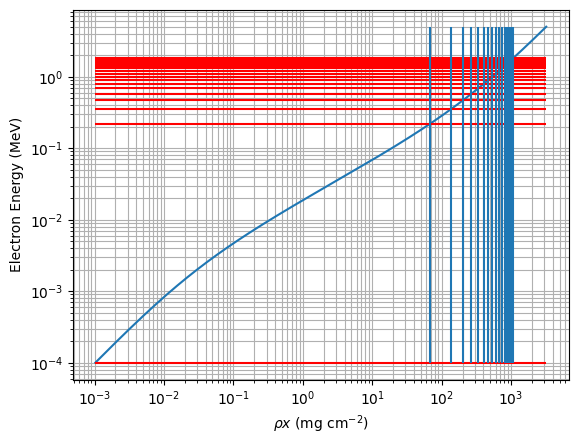

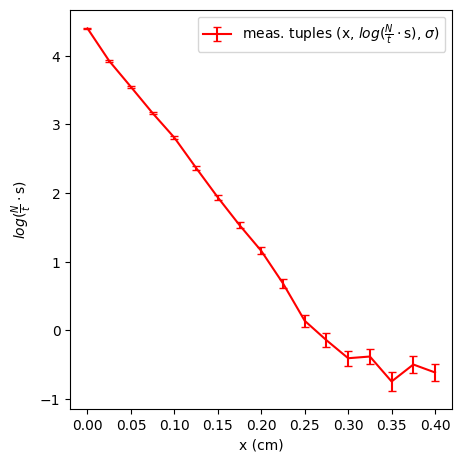

In [547]:
# rho(Al)

rho = u.ufloat(2.69,0.005) * (units.gram / units.centimeter**3)#g/cm^3

N_bg = u.ufloat(73,np.sqrt(73)) * 1 # anzahl in 120 sekunden

# Import meas 3
X_dicke_meas, t_seconds_meas, N_anzahl_meas = np.genfromtxt(os.path.join(os.getcwd(), "meas_3.csv"), delimiter=',', skip_header=1, unpack=True)

u_x = np.array([u.ufloat(X_val, 0.5) for X_val in X_dicke_meas]) * units.millimeter
u_t = np.array([u.ufloat(t_val, 2/1000) for t_val in t_seconds_meas]) * units.seconds
u_N = np.array([u.ufloat(N_val, np.sqrt(N_val)) for N_val in N_anzahl_meas]) * 1

#Berechnung N eff
u_Neff = extr_values(u_N-N_bg) * 1
u_Neff = [u.ufloat(n if n >= 1.0 else 1.0, np.sqrt(n) if n>=1.0 else 1.0) for n in u_Neff] * 1

#ln N/t
#u_lnNt = u.wrap(np.log)(u_N/u_t)
u_lnNt = np.array([ulog(u_N[i]/u_t[i].magnitude) for i in range(0, len(u_N))]) * 1

#Umwandlung in cm
u_x_cm = u_x/10 * (units.centimeter / units.millimeter)

#rho * x
rho_x = rho * u_x_cm
print("rho*x = ", rho_x)
rho_x_mg_per_cmsq = rho_x.to(units.mg/units.cm**2)# * (units.milligram / units.gram * 1000)

# E(rho*x) Energieverlust
Energies, Energies_sig = Approx_E_of_px(extr_values(rho_x_mg_per_cmsq), np.zeros(len(rho_x_mg_per_cmsq)))
u_Energies = np.array([u.ufloat(Energies[i], Energies_sig[i]) * units.MeV for i in range(0, len(Energies))])

# u_x: np.array(u.ufloat) * ureq.unit{optional}
# u_y: np.array(u.ufloat) * ureq.unit{optional}
def graph_1(u_x, u_y,
    xlabel='xlabel', ylabel='ylabel', legloc='upper left',
    do_linfit=False,
    y_axis_log=False, x_axis_log=False,
    figsize=(12*cm, 12*cm)
):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    
    # Extract values and uncertainties from uncertainty arrays
    X, Y, sig_Y = extr_values(u_x), extr_values(u_y), extr_sig(u_y)
    
    if y_axis_log:
        ax.set_yscale("log")
    if x_axis_log:
        ax.set_xscale("log")
    
    if do_linfit:
        fit_result = scipy.stats.linregress(X, Y)
        u_Slope = u.ufloat(fit_result.slope, fit_result.stderr)
        u_Intercept = u.ufloat(fit_result.intercept, fit_result.intercept_stderr)
        #slope, intercept, rvalue, pvalue, sevalue, inteerr
        print("slope: ", fit_result.slope)
        print("slope_err:", fit_result.stderr)
        print("intercept: ", fit_result.intercept)
        x_axis_spaced = np.linspace(np.min(X), np.max(X), 100)
        ax.plot(x_axis_spaced, fit_result.slope*x_axis_spaced + fit_result.intercept,
            'b--', label=r'm{}+b = ({:.1u}){} + ({:.1uP})'.format(xlabel, u_Slope, xlabel, u_Intercept))
    
    #ax.plot(x_axis_spaced, result.slope*x_axis_spaced + result.intercept, 'r--', label='label')
    ax.errorbar(X, Y, yerr=sig_Y, linestyle='-', color='red', capsize=3, label='meas. tuples ({}, {}, {})'.format(xlabel, ylabel, r'$\sigma$'))

    # Pretty print units
    units.setup_matplotlib(True)
    if hasattr(u_x, 'units'):
        ax.xaxis.set_units(u_x.units)
        ax.set_xlabel("{} ({:~P})".format(xlabel, u_x.units))
    else:
        ax.set_xlabel(xlabel)
    if hasattr(u_y, 'units'):
        ax.yaxis.set_units(u_y.units)
        ax.set_ylabel("{} ({:~P})".format(ylabel, u_y.units))
    else:
        ax.set_ylabel(ylabel)
    
    ax.legend(loc=legloc)
    plt.tight_layout()
    plt.savefig('graph1.png', dpi=500)
    plt.show()

    if do_linfit:
        return u_Slope, u_Intercept


graph_1(u_x_cm, u_lnNt,
    xlabel="x", ylabel=r'$log(\frac{N}{t}\cdot\mathrm{s})$',
    legloc='upper right')

xmax = 0.300+/-0.070 centimeter


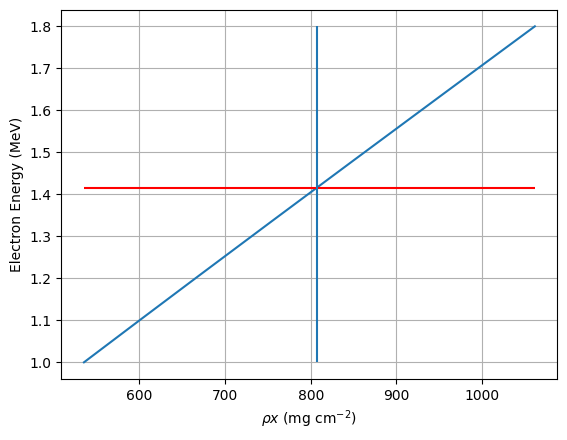

E_max = 1.42+/-0.57 MeV


In [548]:
x_max = u.ufloat(0.30, 0.07) * units.centimeter
print("xmax = {:.2u}".format(x_max))

rho_xmax = rho*x_max
#rho_xmax_mg_per_cmsq = rho_xmax * (units.milligram / units.gram * 1000)
rho_xmax_mg_per_cmsq = rho_xmax.to(units.mg / units.cm**2)

E_max, E_max_unc = Approx_E_of_px(rho_xmax_mg_per_cmsq.nominal_value, rho_xmax_mg_per_cmsq.std_dev, customrange=True, E_range_min=1.0, E_range_max=1.8, nologlog=True)

u_E_max = u.ufloat(E_max, E_max_unc) * units.MeV

print("E_max = {:.2u~P}".format(u_E_max))

In [549]:
# Calculate Activities
def calc_activity(u_Neff, u_t):
    u_epsilon = u.ufloat(0.00180, 0.00011)
    u_fact = u.ufloat(1.48, 0.01)
    u_epsilons = np.ones(len(u_Neff))*u_epsilon
    u_facts = np.ones(len(u_Neff))*u_fact
    udivide = u.wrap(np.divide)
    umultiply = u.wrap(np.multiply)
    return udivide(umultiply(u_facts, u_Neff), (umultiply(u_t, u_epsilons)))
u_calc_activity = u.wrap(calc_activity)

u_Activities = u_calc_activity(u_Neff, u_t)

In [550]:
Energy_Loss = u.ufloat(105, 3) * units.keV
Energy_Loss

105.0+/-3.0 <Unit('kiloelectron_volt')>

In [551]:
E_max_Quelle = Energy_Loss + u_E_max
E_max_Quelle.to(units.MeV)

1.5206281562815627+/-0.5717495880498207 <Unit('megaelectron_volt')>

slope:  -16.554651298895962
slope_err: 0.1851240423870986
intercept:  4.40310316997736


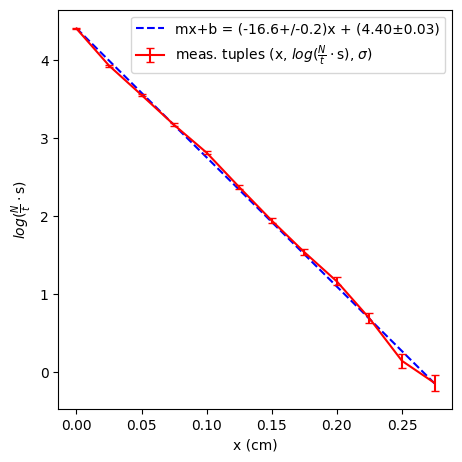

mu = 16.55+/-0.19
d) Emax from Eq. 4 = 2.035+/-0.016 MeV
E max quelle Eq. 4 = 2.140+/-0.016 MeV


(1.415628156281563+/-0.5717417174171742 <Unit('megaelectron_volt')>,
 array([<Quantity(0.0001+/-0, 'megaelectron_volt')>,
        <Quantity(0.21789782197821977+/-0, 'megaelectron_volt')>,
        <Quantity(0.34814651946519465+/-0, 'megaelectron_volt')>,
        <Quantity(0.4660953399533995+/-0, 'megaelectron_volt')>,
        <Quantity(0.5783442174421745+/-0, 'megaelectron_volt')>,
        <Quantity(0.6873431274312743+/-0, 'megaelectron_volt')>,
        <Quantity(0.7942920579205792+/-0, 'megaelectron_volt')>,
        <Quantity(0.8997410034100342+/-0, 'megaelectron_volt')>,
        <Quantity(1.004189958899589+/-0, 'megaelectron_volt')>,
        <Quantity(1.107838922389224+/-0, 'megaelectron_volt')>,
        <Quantity(1.2108878918789188+/-0, 'megaelectron_volt')>,
        <Quantity(1.3134868658686587+/-0, 'megaelectron_volt')>,
        <Quantity(1.4156358443584436+/-0, 'megaelectron_volt')>,
        <Quantity(1.5175348253482535+/-0, 'megaelectron_volt')>,
        <Quantity(1.6191338093380

In [552]:
# 3.4 d)

i_max = len(u_x_cm)-1
for i in range(0,len(u_x_cm)):
    if u_x_cm[i] >= x_max:
        i_max = i-1
        break
    
u_Slope, u_Intercept = graph_1(u_x_cm[0:i_max], u_lnNt[0:i_max],
    xlabel="x", ylabel=r'$log(\frac{N}{t}\cdot\mathrm{s})$',
    legloc='upper right', do_linfit=True
)

u_mu = -u_Slope
print("mu = {:.2u}".format(u_mu))

# inputs without units
def solve_Eq4_for_E_max(mu, rho):
    exponent = 1.43
    A_fact = 17
    Emax_tothe_exponent = (A_fact*rho)/mu
    u_E_max = upower(Emax_tothe_exponent, 1.0/exponent)
    return u_E_max
usolve_Eq4_for_E_max = (u.wrap(solve_Eq4_for_E_max))

u_E_max_Eq4 = usolve_Eq4_for_E_max(u_mu,rho.magnitude) * units.MeV
print("d) Emax from Eq. 4 = {:.2u~P}".format(u_E_max_Eq4))

u_E_max_Quelle_Eq4 = (Energy_Loss + u_E_max_Eq4).to(units.MeV)
print("E max quelle Eq. 4 = {:.2u~P}".format(u_E_max_Quelle_Eq4))

u_E_max, u_Energies


### 3.5

slope:  4.7885810300162674
slope_err: 0.2782844996202975
intercept:  5.509991512279852


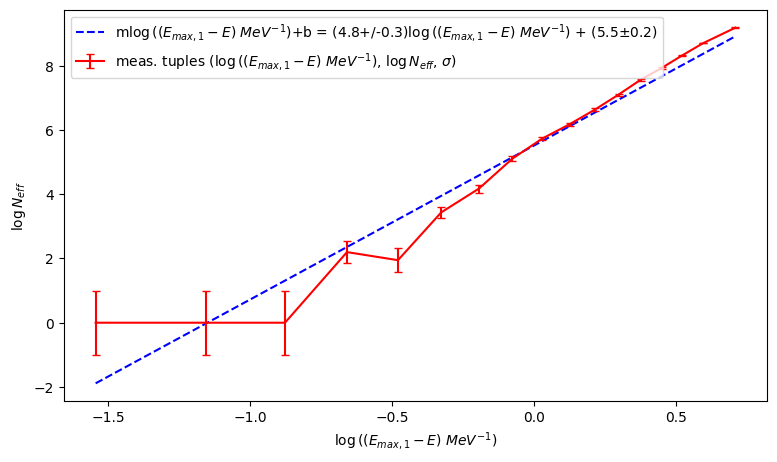

n = 4.79+/-0.28
[9699.0+/-98.48350115628506, 6008.0+/-77.5112895003044, 4093.0+/-63.97655820689325, 2768.0+/-52.61178575186362, 1916.0+/-43.77213725647858, 1207.0+/-34.741905532080416, 760.0+/-27.568097504180443, 483.0+/-21.97726097583591, 309.0+/-17.578395831246947, 165.0+/-12.84523257866513, 65.0+/-8.06225774829855, 31.0+/-5.5677643628300215, 7.0+/-2.6457513110645907, 9.0+/-3.0, 1.0+/-1.0, 1.0+/-1.0, 1.0+/-1.0] [9.179778066393542+/-0.010153985066118679
 8.700847193443972+/-0.012901346454777697
 8.317033476492403+/-0.015630725191031824
 7.92588031673756+/-0.019007148031742638
 7.557994958530806+/-0.02284558311924769
 7.095893221097532+/-0.028783683125170184
 6.633318433280377+/-0.03627381250550058
 6.180016653652572+/-0.04550157551932901
 5.733341276897746+/-0.056888012398857435
 5.10594547390058+/-0.0778498944161523
 4.174387269895637+/-0.12403473458920845
 3.4339872044851463+/-0.17960530202677488
 1.9459101490553132+/-0.3779644730092272
 2.1972245773362196+/-0.3333333333333333 0.0+/

In [553]:
bTakeEmaxFromEq4 = True
bExcludePointsForSafety = False

#print("Emax = {}, u_Energies={}".format(u_E_max, u_Energies))
Emax_minus_E = np.array([(u_E_max_Eq4 if bTakeEmaxFromEq4 else u_E_max) - e for e in u_Energies])# TODO which fucking value of Emax do we use here???

log_Emax_minus_E = np.array([ulog(e.magnitude) for e in Emax_minus_E])
log_Neff = np.array([ ulog(n) for n in u_Neff ])
exclude_points = (3 if bTakeEmaxFromEq4 else 5) # Excluded the points where Neff was calculated as a negative value so excluded non-physical solutions of Neff
u_Slope_35, u_Intercept_35 = graph_1(
    log_Emax_minus_E[:-exclude_points] if bExcludePointsForSafety else log_Emax_minus_E,
    log_Neff[:-exclude_points] if bExcludePointsForSafety else log_Neff,
    xlabel=r'$\log{((E_{max, 1} - E)~MeV^{-1})}$', ylabel=r'$\log{N_{eff}}$', legloc='upper left',
    do_linfit=True,
    y_axis_log=False, x_axis_log=False,
    figsize=(20*cm, 12*cm)
)
n = u_Slope_35
print("n = {:.2u}".format(u_Slope_35))

print(u_Neff, log_Neff)

slope:  -3.4666364227873854
slope_err: 0.09091536291868758
intercept:  6.791572561057588


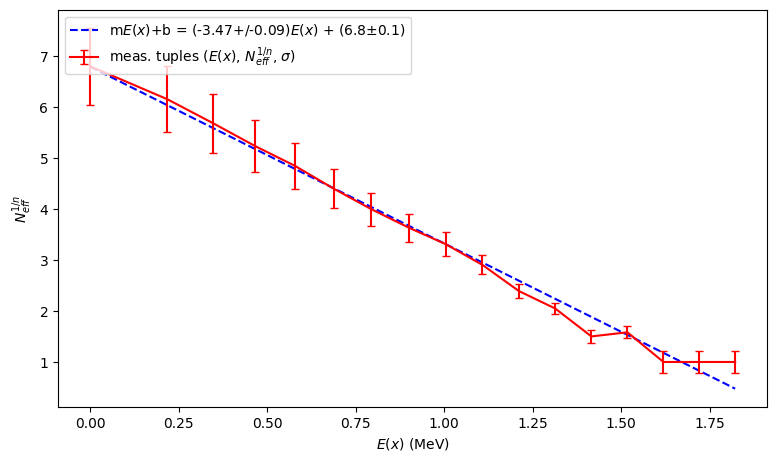

Emax in 3.5 = 1.959+/-0.059 MeV
Emax,Quelle in 3.5 = 2.064+/-0.059 MeV


In [554]:
# Now plot Neff^(1/n) as a function of E(x)
u_Energies_for35 = np.array([e.to(units.MeV)/e.units for e in u_Energies])*units.MeV#[0:-exclude_points]
upower = u.wrap(np.power)
u_Neff_tothe_oneovern = np.power([n if n > 0.0 else u.ufloat(0.0, 0.1) for n in u_Neff], 1.0/n)#[0:-exclude_points],(1.0/n))

u_Slope_35_2, u_Intercept_35_2 = graph_1(u_Energies_for35, u_Neff_tothe_oneovern,
    xlabel=r'$E(x)$', ylabel=r'$N_{eff}^{1/n}$', legloc='upper left',
    do_linfit=True,
    y_axis_log=False, x_axis_log=False,
    figsize=(20*cm, 12*cm)
)
u_E_max_35 = -1.0 * u_Intercept_35_2 / u_Slope_35_2 * units.MeV
u_E_max_Quelle_35 = Energy_Loss + u_E_max_35
print("Emax in 3.5 = {:.2u~P}".format(u_E_max_35))
print("Emax,Quelle in 3.5 = {:.2u~P}".format(u_E_max_Quelle_35.to(units.MeV)))